✅ Classifying Chest X-ray images into Normal, Pneumonia, and COVID-19 using a Deep learning model.

✅ Enhancing interpretability

✅ Building a trustworthy AI system that helps doctors understand model predictions.

In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [3]:
BATCH_SIZE = 32
IMG_SIZE = 224
CHANNELS = 3 #RGB

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Data",
    shuffle=True,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE
)

Found 6432 files belonging to 3 classes.


In [5]:
class_names=dataset.class_names
class_names

['COVID19', 'NORMAL', 'PNEUMONIA']

In [6]:
print(len(dataset))

201


In [7]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 224, 224, 3)
[1 2 1 2 2 2 1 2 1 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2]


In [8]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0])#It is a tensor Object

tf.Tensor(
[[[ 0.         0.         0.       ]
  [ 0.         0.         0.       ]
  [ 0.         0.         0.       ]
  ...
  [25.890625  25.890625  25.890625 ]
  [21.388706  21.388706  21.388706 ]
  [20.30134   20.30134   20.30134  ]]

 [[ 0.         0.         0.       ]
  [ 0.         0.         0.       ]
  [ 0.         0.         0.       ]
  ...
  [24.122768  24.122768  24.122768 ]
  [22.265625  22.265625  22.265625 ]
  [20.959507  20.959507  20.959507 ]]

 [[ 0.         0.         0.       ]
  [ 0.         0.         0.       ]
  [ 0.         0.         0.       ]
  ...
  [24.05542   24.05542   24.05542  ]
  [21.400217  21.400217  21.400217 ]
  [20.578125  20.578125  20.578125 ]]

 ...

 [[ 8.72871    8.72871    8.72871  ]
  [20.241089  20.241089  20.241089 ]
  [24.439333  24.439333  24.439333 ]
  ...
  [54.671875  54.671875  54.671875 ]
  [38.609375  38.609375  38.609375 ]
  [27.071411  27.071411  27.071411 ]]

 [[ 9.6534195  9.6534195  9.6534195]
  [16.022217  16.022217  1

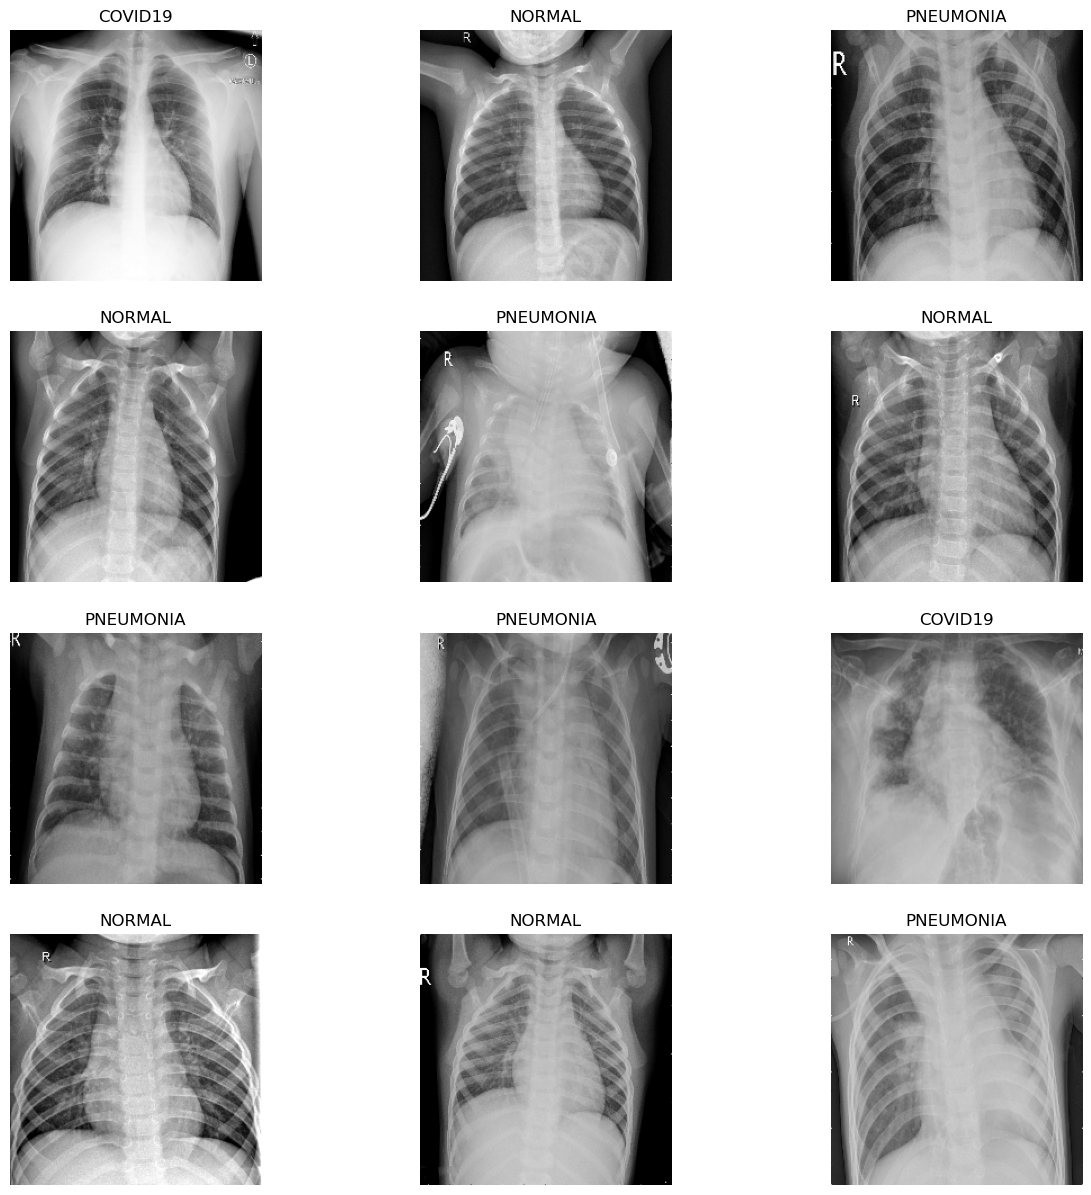

In [9]:
plt.figure(figsize=(15,15))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(4,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

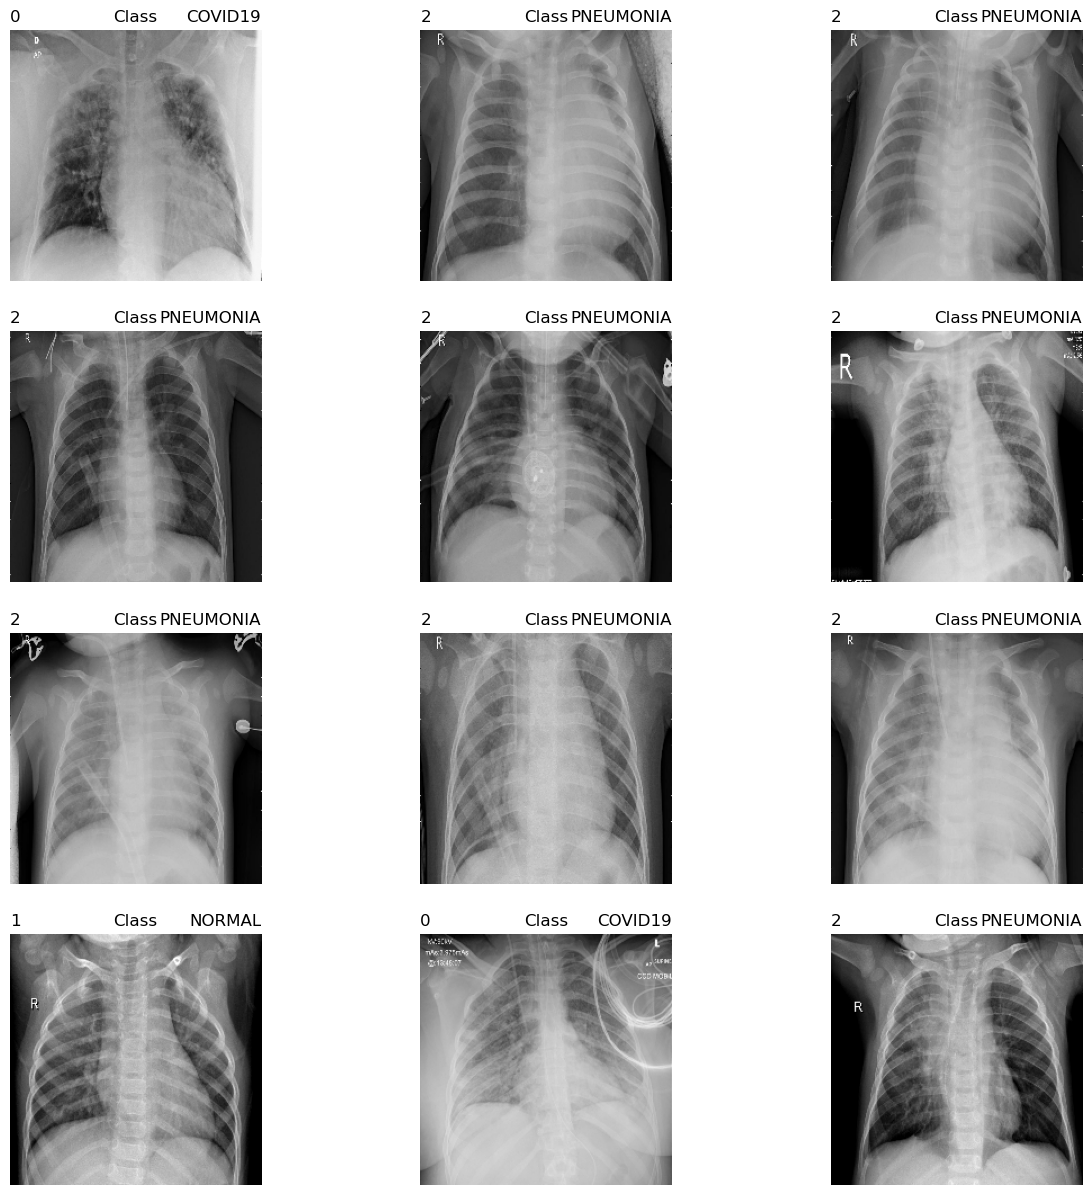

In [10]:
plt.figure(figsize=(15,15))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(4,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8")) #unit8 has to be Mentioned Because it Consideres it as float
        plt.title("Class")
        plt.title(label_batch[i].numpy(), loc='left')
        plt.title(class_names[label_batch[i]], loc='right')
        plt.axis("off")

In [11]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [12]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [13]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

160
20
21


In [14]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE), 
    layers.Rescaling(1.0 / 255)  # Normalize pixel values
])

In [16]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1), 
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

In [17]:
for im_b,lab_b in train_ds.take(1):
    print(im_b.shape) #Input Image Size

(32, 224, 224, 3)


In [18]:
NUM_CLASSES = 3 

In [19]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# Load DenseNet121 with pre-trained ImageNet weights
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze the base model (initial training phase)
base_model.trainable = False

# Define the model architecture
model = models.Sequential([
    resize_and_rescale,  # Step 1: Resize & Rescale
    data_augmentation,  # Step 2: Apply Augmentation
    base_model,  # Step 3: Feature Extractor (DenseNet121)
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),  # Prevent Overfitting
    layers.Dense(3, activation='softmax')  # 3 Classes: Pneumonia, COVID-19, Normal
])
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Lower LR for stability
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,037,504 (26.85 MB)

In [23]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10,verbose=1)

Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 379s 2s/step - accuracy: 0.7141 - loss: 0.6990 - val_accuracy: 0.9094 - val_loss: 0.2740
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 395s 2s/step - accuracy: 0.8544 - loss: 0.3503 - val_accuracy: 0.9094 - val_loss: 0.2444
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 393s 2s/step - accuracy: 0.8810 - loss: 0.2995 - val_accuracy: 0.9109 - val_loss: 0.2402
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 390s 2s/step - accuracy: 0.9027 - loss: 0.2584 - val_accuracy: 0.9359 - val_loss: 0.1837
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 421s 3s/step - accuracy: 0.9101 - loss: 0.2287 - val_accuracy: 0.9328 - val_loss: 0.1832
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 421s 3s/step - accuracy: 0.9117 - loss: 0.2312 - val_accuracy: 0.9391 - val_loss: 0.1627
Epoch 7/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 411s 3s/step - accuracy: 0.9148 - loss: 0.2154 - val_accuracy: 0.9156 - val_loss: 0.2078
Epoch 8/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 387s 2s/step - accuracy: 0.9236 - loss: 0.2089 - val_accu

# Fine-Tune the Model

In [56]:
for layer in base_model.layers[-100:]:  
    layer.trainable = True  

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

In [65]:
history_fine = model.fit(train_ds, 
                         validation_data=val_ds,  
                         epochs=10,
                         verbose=1,
                         callbacks=[callback, reduce_lr])

Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 452s 3s/step - accuracy: 0.5977 - loss: 1.2097 - val_accuracy: 0.9484 - val_loss: 0.1516 - learning_rate: 1.0000e-05
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 450s 3s/step - accuracy: 0.9076 - loss: 0.2651 - val_accuracy: 0.9484 - val_loss: 0.1538 - learning_rate: 1.0000e-05
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 451s 3s/step - accuracy: 0.9145 - loss: 0.2311 - val_accuracy: 0.9484 - val_loss: 0.1490 - learning_rate: 1.0000e-05
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 501s 3s/step - accuracy: 0.9309 - loss: 0.2162 - val_accuracy: 0.9547 - val_loss: 0.1214 - learning_rate: 1.0000e-05
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 449s 3s/step - accuracy: 0.9254 - loss: 0.1957 - val_accuracy: 0.9594 - val_loss: 0.1226 - learning_rate: 1.0000e-05
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 442s 3s/step - accuracy: 0.9366 - loss: 0.1697 - val_accuracy: 0.9625 - val_loss: 0.1111 - learning_rate: 1.0000e-05
Epoch 7/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 451s 3s/step - acc

In [67]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"\nTest Accuracy: {test_acc:.4f}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.9700 - loss: 0.1084

Test Accuracy: 0.9643


In [69]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,724,235 (44.72 MB)

 Trainable params: 2,211,779 (8.44 MB)

 Non-trainable params: 5,088,896 (19.41 MB)

 Optimizer params: 4,423,560 (16.87 MB)

In [71]:
model.save("../models/chest_xray_model.h5")  